# SISO + Noise

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Consider the following single-degree-of-freedom "damped oscillator".

parameter | value
----------|-------
m  | mass
k  | stiffness
c  | damping coefficient

![sdof](./figures/sdof.png)

The oscillator is subject to the following forcing function:

$f(t) = e^{-at}\sin{bt}$

Text(0.5, 1.0, 'Forcing over time (a=1.00, b=3.14)')

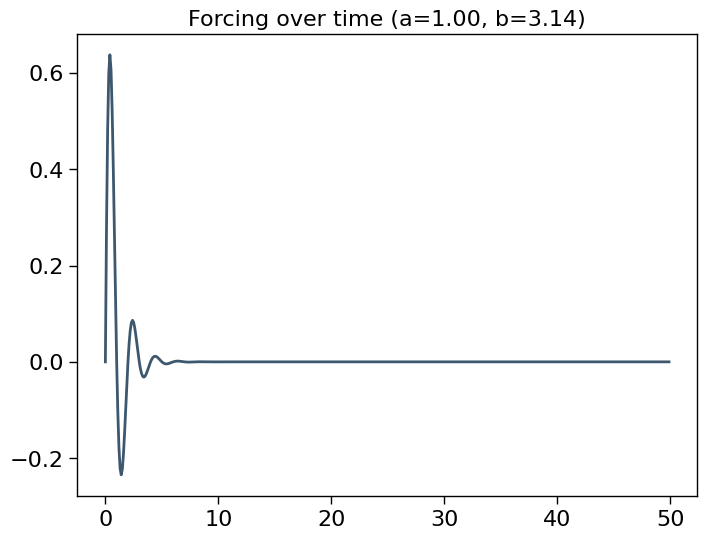

In [2]:
a = 1
b = np.pi
nt = 500
dt = 0.1
time = np.arange(0,nt*dt,dt)
force = np.exp(-a*time)*np.sin(b*time)
plt.plot(time, force)
plt.title(f"Forcing over time ({a=:.2f}, {b=:.2f})")

The differential equation governing the motion of the oscillator is

$m\ddot{u} + c\dot{u} + ku = f(t), \quad{} u(0)=u_{0}, \quad{} \dot{u}(0)=\dot{u}_{0}$.

Assuming $c^{2}-4mk < 0$, and $b \neq \frac{\sqrt{4mk-c^{2}}}{2m}$, the oscillator's response is

$$u(t) = C_{1}e^{-\frac{c}{2m}t\cos{\left(\frac{\sqrt{4mk-c^{2}}}{2m}t\right)}} + C_{2}e^{-\frac{c}{2m}t\sin{\left(\frac{\sqrt{4mk-c^{2}}}{2m}t\right)}} + C_{3}e^{-at}\cos{bt} + C_{4}e^{-at}\sin{bt}$$

$$
C_{3} = \frac{ -(2mab+cb) }{ (ma^{2}-mb^{2}-ca+k)^{2} - (2mab+cb)(2mab-cb) }
$$
$$
C_{4} = \frac{ (ma^{2}-mb^{2}-ca+k) }{ (ma^{2}-mb^{2}-ca+k)^{2} - (2mab+cb)(2mab-cb) }
$$
$$
C_{1} = u_{0} - C_{3}
$$
$$
C_{2} = \frac{ 2m }{ \sqrt{4mk-c^{2}} }\left( \frac{c}{2m}C_{1} + aC_{3} - bC_{4} + \dot{u}_{0} \right)

The response of the oscillator is plotted alongside the input forcing below.

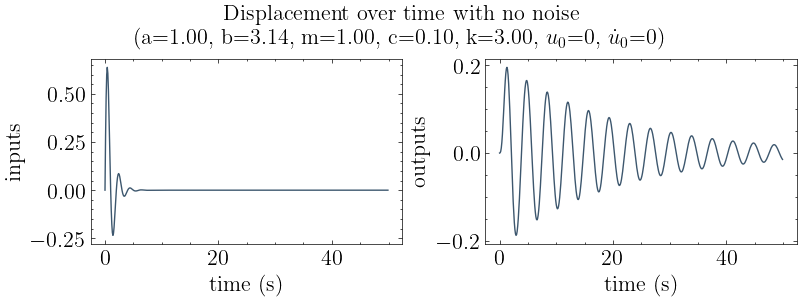

In [3]:
m = 1
c = 0.1
k = 3
a = 1
b = np.pi
u0 = 0
udot0 = 0
force = np.exp(-a*time)*np.sin(b*time)
import sdof
response,_,_ = sdof.integrate(force,dt,k,c,m)
title = "Displacement over time with no noise\n" \
          rf"({a=:.2f}, {b=:.2f}, {m=:.2f}, {c=:.2f}, {k=:.2f}, $u_{0}$={u0}, $\dot u_{0}$={udot0})"
from mdof.utilities.printing import plot_io
plot_io(inputs=force, outputs=response, t=time, title=title)

## 1. Perform System Identification - No Noise

In [4]:
# Generate a state space realization of the system
import mdof
from mdof.utilities.printing import print_modes
A,B,C,D = mdof.system(inputs=force, outputs=response, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = mdof.modal.system_modes((A,B,C,D),dt,outlook=190)
# Actual period
Tn = 2*np.pi*np.sqrt(m/k)
zeta = c/(2*np.sqrt(m*k))
print("\nACTUAL VALUES")
print(f"Actual period: {np.round(Tn,3)}s; Actual damping: {np.round(zeta,3)}")
print("\nPREDICTED/IDENTIFIED VALUES FROM DATA")
print_modes(ss_modes, Tn=Tn, zeta=zeta)

100%|█████████▉| 200/201 [00:00<00:00, 63072.24it/s]


ACTUAL VALUES
Actual period: 3.628s; Actual damping: 0.029

PREDICTED/IDENTIFIED VALUES FROM DATA
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC     T % error    ζ % error
      3.637      0.02872    1.0        1.0        1.0          0.2491       -0.4964  
Mean Period(s): 3.6366347003385524
Standard Dev(s): 0.0


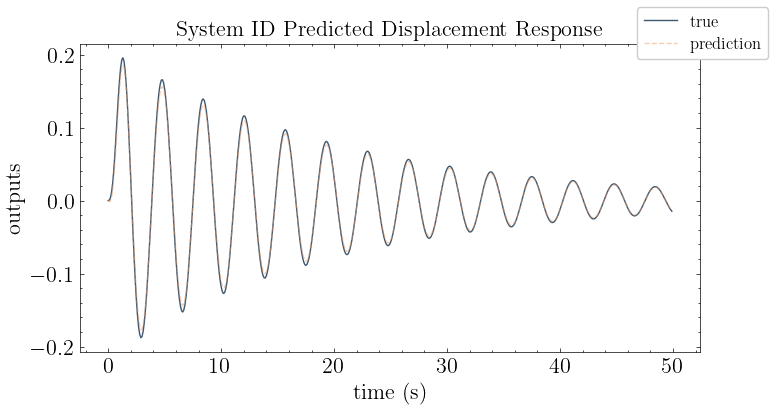

In [5]:
# Reproduce the response with the state space model
from mdof.utilities.testing import forced_response
from mdof.utilities.printing import plot_pred
from control import ss
y_mdof = forced_response(ss(A,B,C,D,dt), T=time, U=force, squeeze=False, return_x=False).outputs
plot_pred(ytrue=response, models=y_mdof, t=time, title="System ID Predicted Displacement Response")

## 2. Perform System Identification - With noise in input

Add noise with standard deviation of $\sigma=1$ and mean of $\mu=0$ to the input, `force`, using [`np.random.normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html).

In [7]:
# Add noise to force
force_with_noise = force + np.random.normal(...)

Generate the response.

In [ ]:
response_from_noisy,_,_ = sdof.integrate(force_with_noise,dt,k,c,m)
title = "Displacement over time, from noisy forcing"
plot_io(inputs=force_with_noise, outputs=response, t=time, title=title)

In [13]:
# Generate a state space realization of the system
A,B,C,D = mdof.system(inputs=force_with_noise, outputs=response_from_noisy, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = mdof.modal.system_modes((A,B,C,D),dt,outlook=190)
# Actual period
Tn = 2*np.pi*np.sqrt(m/k)
zeta = c/(2*np.sqrt(m*k))
print("\nACTUAL VALUES")
print(f"Actual period: {np.round(Tn,3)}s; Actual damping: {np.round(zeta,3)}")
print("\nPREDICTED/IDENTIFIED VALUES FROM DATA")
print_modes(ss_modes, Tn=Tn, zeta=zeta)

In [14]:
# Reproduce the response with the state space model
y_mdof = forced_response(ss(A,B,C,D,dt), T=time, U=force_with_noise, squeeze=False, return_x=False).outputs
plot_pred(ytrue=response_from_noisy, models=y_mdof, t=time, title="System ID Predicted Displacement Response")

## 3. Perform System Identification - With noise in both input and output

Add noise with standard deviation of $\sigma=1$ and mean of $\mu=0$ to the output, `response_from_noisy`, using [`np.random.normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html).

In [10]:
# Add noise to response
noisy_response = response_from_noisy + np.random.normal(...)# 

In [11]:
# Generate a state space realization of the system
A,B,C,D = mdof.system(inputs=force_with_noise, outputs=noisy_response, r=2)
# Obtain natural period and damping ratio from the state space model
ss_modes = mdof.modal.system_modes((A,B,C,D),dt,outlook=190)
# Actual period
Tn = 2*np.pi*np.sqrt(m/k)
zeta = c/(2*np.sqrt(m*k))
print("\nACTUAL VALUES")
print(f"Actual period: {np.round(Tn,3)}s; Actual damping: {np.round(zeta,3)}")
print("\nPREDICTED/IDENTIFIED VALUES FROM DATA")
print_modes(ss_modes, Tn=Tn, zeta=zeta)

In [12]:
# Reproduce the response with the state space model
y_mdof = forced_response(ss(A,B,C,D,dt), T=time, U=force_with_noise, squeeze=False, return_x=False).outputs
plot_pred(ytrue=noisy_response, models=y_mdof, t=time, title="System ID Predicted Displacement Response")